In [1]:
import nltk
import re, string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import MultinomialNB

import gensim
from gensim.models import Word2Vec

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
df_Y = ((pd.Categorical(df.Label).codes).astype(int))
print(df.head(5))
print(df_Y)

                                               Title  Label
0  Minor raped by cop in Jharkhand's Hazaribagh, ...  Crime
1  'Saw my brother getting killed': Bhilwara vict...  Crime
2  Delhi Police arrests burglar, recovers huge qu...  Crime
3  Pregnant woman raped by hospital staff in UP’s...  Crime
4  Muzaffarpur: 15-year-old girl thrashed, gang-r...  Crime
[0 0 0 ... 1 1 1]


c:\Users\SHASHWAT\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


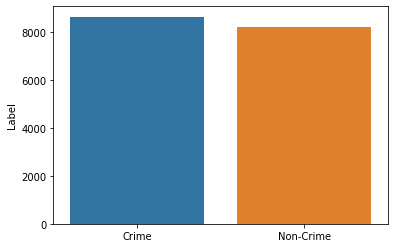

In [6]:
x=df['Label'].value_counts()
sns.barplot(x.index, x);

In [7]:
df['word_count'] = df['Title'].apply(lambda x: len(str(x).split()))
print(df[df_Y==1]['word_count'].mean())
print(df[df_Y==0]['word_count'].mean())

12.699987838988203
11.139798634417312


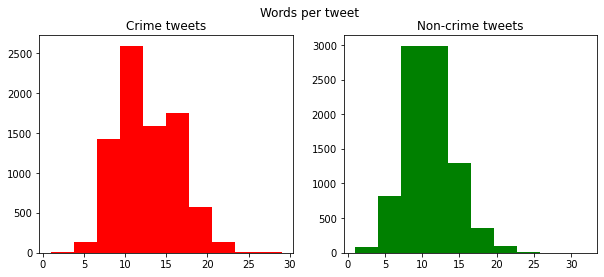

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df_Y==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Crime tweets')
train_words=df[df_Y==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-crime tweets')
fig.suptitle('Words per tweet')
plt.show()

In [9]:
df['char_count'] = df['Title'].apply(lambda x: len(str(x)))
print(df[df_Y==1]['char_count'].mean())
print(df[df_Y==0]['char_count'].mean())

78.22157363492643
69.68128688809166


In [10]:
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text    

In [11]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [12]:
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

In [13]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df['clean_text'] = df['Title'].apply(lambda x: finalpreprocess(x))
df.head()

,Title,Label,word_count,char_count,clean_text
0,"Minor raped by cop in Jharkhand's Hazaribagh, ...",Crime,9,64,minor rap cop jharkhand hazaribagh accuse abscond
1,'Saw my brother getting killed': Bhilwara vict...,Crime,14,94,saw brother get kill bhilwara victim brother r...
2,"Delhi Police arrests burglar, recovers huge qu...",Crime,12,87,delhi police arrest burglar recovers huge quan...
3,Pregnant woman raped by hospital staff in UP’s...,Crime,11,75,pregnant woman rap hospital staff ups mirzapur...
4,"Muzaffarpur: 15-year-old girl thrashed, gang-r...",Crime,7,71,muzaffarpur year old girl thrash gang rap accu...


In [14]:
df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['clean_text']]
model = Word2Vec(df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(df['clean_text'], df_Y, test_size=0.2, random_state=42)

In [16]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [17]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)#building Word2Vec model

modelw = MeanEmbeddingVectorizer(w2v)# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [44]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, Y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print(accuracy_score(Y_test, y_predict))
print(classification_report(Y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(Y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc) 

0.8787429587903943
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1748
           1       0.86      0.90      0.88      1625

    accuracy                           0.88      3373
   macro avg       0.88      0.88      0.88      3373
weighted avg       0.88      0.88      0.88      3373

Confusion Matrix: [[1502  246]
 [ 163 1462]]
AUC: 0.9513362084140117


In [45]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, Y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print(accuracy_score(Y_test, y_predict))
print(classification_report(Y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(Y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc) 

0.8769641268900089
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1748
           1       0.86      0.89      0.87      1625

    accuracy                           0.88      3373
   macro avg       0.88      0.88      0.88      3373
weighted avg       0.88      0.88      0.88      3373

Confusion Matrix: [[1506  242]
 [ 173 1452]]
AUC: 0.9490513994015137


In [46]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, Y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 
print(accuracy_score(Y_test, y_predict))
print(classification_report(Y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(Y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

0.8013637711236288
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1748
           1       0.74      0.89      0.81      1625

    accuracy                           0.80      3373
   macro avg       0.81      0.80      0.80      3373
weighted avg       0.81      0.80      0.80      3373

Confusion Matrix: [[1249  499]
 [ 171 1454]]
AUC: 0.882926069353987
